# 4.1 Linear Regression

Linear regression:
- Using a direct 'closed-form' equation that directly computes the model parameters that best fit the model to the training set (i.e. the model parameters that minimize the cost function over the training set)
- Using an iterative optimization approach called Gradient Descent (GD) that gradually tweaks the model parameters to minimize the cost function over the training set, eventually converging to the same set of parameters as the first method. We will look at a few variants of Gradient Descent that we will use again and again when we study neural networks, Batch GD, Mini-batch GD, and Stochastic GD

## 4.1.1 The normal equation

To find the value of parameters that minimize the cost function MSE, there is a closed-form solution, in other words, a mathematical equation that gives the result directly. This is called the Normal Equation

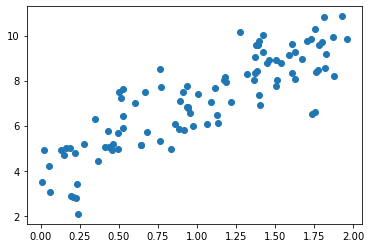

In [6]:
import numpy as np
import matplotlib.pyplot as plt

X = 2 * np.random.rand(100, 1)
y = 4 + 3 * X + np.random.randn(100, 1)

plt.scatter(X, y)

In [10]:
X_b = np.c_[np.ones((100, 1)), X] # add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
theta_best

array([[3.94755396],
       [3.07625829]])

In [13]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2, 1)), X_new] # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[ 3.94755396],
       [10.10007054]])

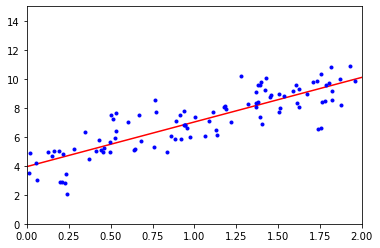

In [20]:
plt.plot(X_new, y_predict, 'r-')
plt.plot(X, y, 'b.')
plt.axis([0, 2, 0, 15])
plt.show()

In [23]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y)

LinearRegression()

In [24]:
lin_reg.intercept_, lin_reg.coef_

(array([3.94755396]), array([[3.07625829]]))

In [25]:
lin_reg.predict(X_new)

array([[ 3.94755396],
       [10.10007054]])

The LinearRegression class is based on the scipy.linalg.lstsq() function (the name stands for “least squares”), which you could call directly:

In [26]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b, y, rcond = 1e-6)
theta_best_svd

array([[3.94755396],
       [3.07625829]])

In [27]:
np.linalg.pinv(X_b).dot(y)

array([[3.94755396],
       [3.07625829]])

## 4.1.2 Computational complexity

Singular Value Decomposition (SVD)

# 4.2 Gradient Descent

Gradient Descent is a generic optimization algorithm capable of finding optimal solutions to a wide range of problems. The general idea of Gradient Descent is to tweak parameters iteratively in order to minimize a cost function.

Suppose you are lost in the mountains in a dense fog, and you can only feel the slope of the ground below your feet. A good strategy to get to the bottom of the valley quickly is to go downhill in the direction of the steepest slope. This is exactly what Gradient Descent does: it measures the local gradient of the error function with regard to the parameter vector θ, and it goes in the direction of descending gradient. Once the gradient is zero, you have reached a minimum!

Concretely, you start by filling θ with random values (this is called random initialization). Then you improve it gradually, taking one baby step at a time, each step attempting to decrease the cost function (e.g., the MSE), until the algorithm converges to a minimum

An important parameter in Gradient Descent is the size of the steps, determined by the learning rate hyperparameter. If the learning rate is too small, then the algorithm will have to go through many iterations to converge, which will take a long time

On the other hand, if the learning rate is too high, you might jump across the valley and end up on the other side, possibly even higher up than you were before. This might make the algorithm diverge, with larger and larger values, failing to find a good solution

Finally, not all cost functions look like nice, regular bowls. There may be holes, ridges, plateaus, and all sorts of irregular terrains, making convergence to the minimum difficult

Local minimum and global minimum

Fortunately, the MSE cost function for a Linear Regression model happens to be a convex function, which means that if you pick any two points on the curve, the line segment joining them never crosses the curve. This implies that there are no local minima, just one global minimum. It is also a continuous function with a slope that never changes abruptly. These two facts have a great consequence: Gradient Descent is guaranteed to approach
arbitrarily close the global minimum (if you wait long enough and if the learning rate is not too high).

In fact, the cost function has the shape of a bowl, but it can be an elongated bowl if the features have very different scales

When using gradient descent, ensure that all features have a similar scale(e.g. using Scikit-Learn's StandardScaler class), or else it will take much longer to converge

Training a model means searching for a combination of model parameters that minimizes a cost function (over the training set). It is a search in the model’s parameter space: the more parameters a model has, the more dimensions this space has, and the harder the search is: searching for a needle in a 300-dimensional haystack is much trickier than in 3 dimensions. Fortunately, since the cost function is convex in the case of Linear Regression, the needle is simply at the bottom of the bowl.

## 4.2.1 Batch gradient descent

**Partial derivative**:To implement Gradient Descent, you need to compute the gradient of the cost function with regard to each model parameter θj . In other words, you need to calculate how much the cost function will change if you change θj just a little bit. This is called a partial derivative. It is like asking “What is the slope of the mountain under my feet if I face east?” and then asking the same question facing north (and so on for all other dimensions, if you can imagine a universe with more than three dimensions).

The gradient vector, noted ∇ MSE(θ), contains all the partial derivatives of the cost function (one for each model parameter).

Notice that this formula involves calculations over the full training set X, at each Gradient Descent step! This is why the algorithm is called Batch Gradient Descent: it uses the whole batch of training data at every step
(actually, Full Gradient Descent would probably be a better name). As a result it is terribly slow on very large training sets. However, Gradient Descent scales well with the number of features; training a Linear Regression model when there are hundreds of thousands of features is much faster using Gradient Descent than using the Normal Equation or SVD decomposition.

In [32]:
from tqdm.notebook import trange, tqdm

eta = 0.1 # learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2, 1) # random initialization

for iteration in trange(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients

theta

array([[3.94755396],
       [3.07625829]])

To find a good learning rate, you can use grid search. However, you may want to limit the number of iterations so that grid search can eliminate models that take too long to converge

You may wonder how to set the number of iterations. If it is too low, you will still be far away from the optimal solution when the algorithm stops; but if it is too high, you will waste time while the model parameters do not change anymore. A simple solution is to set a very large number of iterations but to interrupt the algorithm when the gradient vector becomes tiny—that is, when its norm becomes smaller than a tiny number ϵ (called the tolerance)—because this happens when Gradient Descent has (almost) reached the minimum.

**Convergence rate:** When the cost function is convex and its slope does not change abruptly (as is the case for the MSE cost function), Batch Gradient Descent with a fixed learning rate will eventually converge to the optimal solution, but you may have to wait a while: it can take O(1/ϵ) iterations to reach the optimum within a range of ϵ, depending on the shape of the cost function. If you divide the tolerance by 10 to have a more precise solution, then the algorithm may have to run about 10 times longer

## 4.2.2 Stochastic gradient descent 

The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. At the opposite extreme, Stochastic Gradient Descent picks a random instance in the training set at every step and computes the gradients based only on that single instance. Obviously, working on a single instance at a time makes the algorithm much faster because it has very little data to manipulate at every iteration. It also makes it possible to train on huge training sets, since only one instance needs to be in memory at each iteration (Stochastic GD can be implemented as an outof- core algorithm; see Chapter 1).

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up
and down, decreasing only on average. Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. So once the algorithm stops, the final parameter values are good, but not optimal.

When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so Stochastic Gradient Descent has a better chance of finding the global minimum than Batch Gradient Descent does

Stochastic gradient descent picks a random instance in the training set at every step and computes the gradients based only on that single instance

Randomness is good to escape from local optima, but bad because it means that the algorithm can never settle at the minimum

One solution to this dilemma is to gradually reduce the learning rate. The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. This process is akin to simulated annealing, an algorithm inspired from the process in metallurgy of annealing, where molten metal is slowly cooled down. The function that determines the learning rate at each iteration is called the learning schedule. If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early.

In [34]:
n_epochs = 50
t0, t1 = 5, 50 # learning schedule hyperparameters 

def learning_schedule(t):
    return t0/(t + t1)

theta = np.random.randn(2, 1) # random initialization 

for epoch in trange(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:randbom_index+1]
        gradients = 2 * xi.T.dot(xi.dot(theta) - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients
    
theta

array([[3.91383844],
       [3.12854402]])

Note that since instances are picked randomly, some instances may be picked several times per epoch, while others may not be picked at all. If you want to be sure that the algorithm goes through every instance at each epoch, another approach is to shuffle the training set (making sure to shuffle the input features and the labels jointly), then go through it instance by instance, then shuffle it again, and so on. However, this approach generally converges more slowly.

When using Stochastic Gradient Descent, the training instances must be independent and identically distributed (IID) to ensure that the parameters get pulled toward the global optimum, on average. A simple way to ensure this is to shuffle the instances during training (e.g., pick each instance randomly, or shuffle the training set at the beginning of each epoch). If you do not shuffle the instances—for example, if the instances are sorted by label—then SGD will start by optimizing for one label, then the next, and so on, and it will not settle close to the global minimum.

In [37]:
from sklearn.linear_model import SGDRegressor

sgd_reg = SGDRegressor(max_iter = 1000, tol = 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X, y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [38]:
sgd_reg.intercept_, sgd_reg.coef_

(array([3.99434563]), array([3.1695303]))

## 4.2.3 Mini-batch gradient descent

At each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-batch GD computes the gradients on small random sets of instances called mini-batches. The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs.

The algorithm’s progress in parameter space is less erratic than with Stochastic GD, especially with fairly large mini-batches. As a result, Minibatch GD will end up walking around a bit closer to the minimum than
Stochastic GD—but it may be harder for it to escape from local minima (in the case of problems that suffer from local minima, unlike Linear Regression).

# 4.3 Polynomial Regression

Use a linear model to fit nonlinear data. A simple way to do this is to add powers of each feature as new features, then train a linear model on this extended set of features. This technique is called Polynomial Regression.

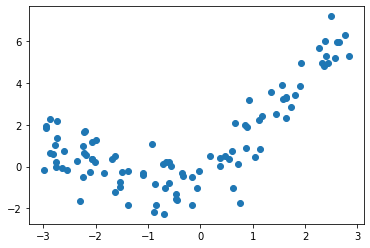

In [42]:
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 0.5 * X ** 2 + X + np.random.randn(m, 1)
plt.scatter(X, y)
plt.show()

use Scikit-Learn’s PolynomialFeatures class to transform our training data, adding the square (second-degree polynomial) of each feature in the training set as "a new feature (in this case there is just one feature):

In [44]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.16906886])

In [45]:
X_poly[0]

array([-0.16906886,  0.02858428])

In [47]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
lin_reg.intercept_, lin_reg.coef_

(array([-0.18272498]), array([[1.02880866, 0.53159556]]))

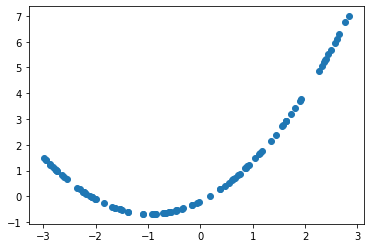

In [53]:
plt.scatter(X, lin_reg.predict(X_poly))

Note that when there are multiple features, Polynomial Regression is capable of finding relationships between features (which is something a plain Linear Regression model cannot do). This is made possible by the fact
that PolynomialFeatures also adds all combinations of features up to the given degree. For example, if there were two features a and b, PolynomialFeatures with degree=3 would not only add the features a2, a3, b2, and b3, but also the combinations ab, a2b, and ab2.

# 4.4 Learning Curves

**Learning curves:** these are plots of the model’s performance on the training set and the validation set as a function of the training set size (or the training iteration). To generate the plots, train the model several times on different sized subsets of the training set. The following code defines a function that, given some training data, plots the learning curves of a model:

In [59]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2)
    train_errors, val_errors = [], []
    for m in trange(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))
    plt.plot(np.sqrt(train_errors), 'r-+', linewidth = 2, label = 'train')
    plt.plot(np.sqrt(val_errors), 'b-', linewidth = 3, label = 'val')
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')

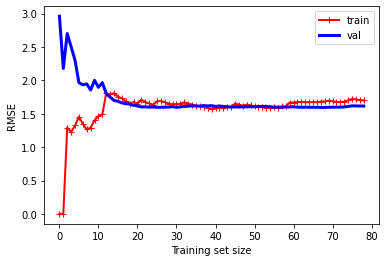

In [60]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

This model that’s underfitting deserves a bit of explanation. First, let’s look at the performance on the training data: when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero. But as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all. So the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or worse. Now let’s look at the performance of the model on the validation data. When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big. Then, as the model is shown more training examples, it learns, and thus the validation error slowly goes down. However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve.

These learning curves are typical of a model that’s underfitting. Both curves have reached a plateau; they are close and fairly high.

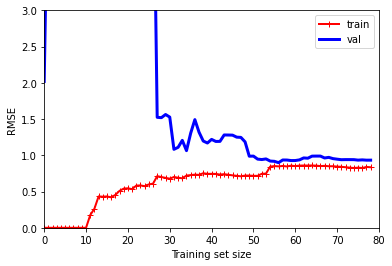

In [67]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 10, include_bias = False)),
    ('lin_reg', LinearRegression())
])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 3])
plt.show()

These learning curves look a bit like the previous ones, but there are two very important differences:
- The error on the training data is much lower than with the Linear Regression model.
- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. If you used a much larger training set, however, the two curves would continue to get closer.

**The bias/variance trade-off:**

An important theoretical result of statistics and Machine Learning is the fact that a model’s generalization error can be expressed as the sum of three very different errors:
- Bias: This part of the generalization error is due to wrong assumptions, such as assuming that the data is linear when it is actually quadratic. A high-bias model is most likely to underfit the training data.
- Variance: This part is due to the model’s excessive sensitivity to small variations in the training data. A model with many degrees of freedom (such as a high-degree polynomial model) is likely to have high variance and thus overfit the training data.
- Irreducible error: This part is due to the noisiness of the data itself. The only way to reduce this part of the error is to clean up the data (e.g., fix the data sources, such as broken sensors, or detect and remove outliers).

Increasing a model's complexity will typically increase its variance and reduce its bias. Conversely, reducing a model's complexity increases its bias and reduces its variance

# 4.5 Regularized Linear Models

## 4.5.1 Ridge regression

Ridge Regression (also called Tikhonov regularization) is a regularized version of Linear Regression: a regularization term is added to the cost function. This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. Note that the regularization term should only be added to the cost function during training. Once the model is trained, you want to use the unregularized performance measure to evaluate the model’s performance.

It is quite common for the cost function used during training to be different from the performance measure used for testing. Apart from regularization, another reason they might be different is that a good training cost function should have optimization-friendly derivatives, while the performance measure used for testing should be as close as possible to the final objective. For example, classifiers are often trained using a cost function such as the log loss but evaluated using precision/recall

The hyperparameter α controls how much you want to regularize the model. If α = 0, then Ridge Regression is just Linear Regression. If α is very large, then all weights end up very close to zero and the result is a flat line going through the data’s mean

It is important to scale the data (e.g. using a StandardScaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models

As with Linear Regression, we can perform Ridge Regression either by computing a closed-form equation or by performing Gradient Descent. The pros and cons are the same

In [69]:
from sklearn.linear_model import Ridge

ridge_reg = Ridge(alpha = 1, solver = 'cholesky')
ridge_reg.fit(X, y)
ridge_reg.predict([[1.5]])

array([[2.68218493]])

In [71]:
sgd_reg = SGDRegressor(penalty = 'l2')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([2.65997089])

## 4.5.2 Lasso regression

Least Absolute Shrinkage and Selection Operator Regression

An important characteristic of Lasso Regression is that it tends to eliminate the weights of the least important features (i.e., set them to zero). In other words, Lasso Regression automatically performs feature selection and outputs a sparse model (i.e., with few nonzero feature weights).

To avoid Gradient Descent from bouncing around the optimum at the end when using Lasso, you need to gradually reduce the learning rate during training (it will still bounce around the optimum, but the steps will get smaller and smaller, so it will converge).

In [78]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso(alpha = 0.1)
lasso_reg.fit(X, y)
lasso_reg.predict([[1.5]])

array([2.62787421])

In [79]:
sgd_reg = SGDRegressor(penalty = 'l1')
sgd_reg.fit(X, y.ravel())
sgd_reg.predict([[1.5]])

array([2.66939303])

## 4.5.3 Elastic net

Elastic Net is a middle ground between Ridge Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms, and you can control the mix ratio r. When r = 0, Elastic Net is equivalent to Ridge Regression, and when r = 1, it is equivalent to Lasso Regression

So when should you use plain Linear Regression (i.e., without any regularization), Ridge, Lasso, or Elastic Net? It is almost always preferable to have at least a little bit of regularization, so generally you should avoid plain Linear Regression. Ridge is a good default, but if you suspect that only a few features are useful, you should prefer Lasso or Elastic Net because they tend to reduce the useless features’ weights down to zero, as we have discussed. In general, Elastic Net is preferred over Lasso because Lasso may behave erratically when the number of features is greater than the number of training instances or when several features are strongly correlated.

In [82]:
from sklearn.linear_model import ElasticNet

elastic_net = ElasticNet(alpha = 0.1, l1_ratio = 0.5)
elastic_net.fit(X, y)
elastic_net.predict([[1.5]])

array([2.63422471])

## 4.5.4 Early stopping

A very different way to regularize iterative learning algorithms such as Gradient Descent is to stop training as soon as the validation error reaches a minimum. This is called early stopping.

With Stochastic and Mini-batch Gradient Descent, the curves are not so smooth, and it may be hard to know whether you have reached the minimum or not. One solution is to stop only after the validation error has been above the minimum for some time (when you are confident that the model will not do any better), then roll back the model parameters to the point where the validation error was at a minimum

In [ ]:
from sklearn.base import clone 
from sklearn.preprocessing import StandardScaler

# prepare the data
poly_scaler = Pipeline([
    ('poly_features', PolynomialFeatures(degree = 90, include_bias = False)),
    ('std_scaler', StandardScaler())
])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter = 1, 
                       tol = -np.infty, 
                       warm_start = True, 
                       penalty = None, 
                       learning_rate = 'constant',
                       eta0 = 0.0005)

minimum_val_error = float('inf')
best_epoch = None
best_model = None

for epoch in trange(1000):
    sgd_reg.fit(X_train_poly_scaled, y_train) # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        minimum_val_error = val_error
        best_epocj = epoch
        best_model = clone(sgd_reg)

# 4.6 Logistic Regression

Logistic Regression (also called Logit Regression) is commonly used to estimate the probability that an instance belongs to a particular class (e.g., what is the probability that this email is spam?). If the estimated probability is greater than 50%, then the model predicts that the instance belongs to that class (called the positive class, labeled “1”), and otherwise it predicts that it does not (i.e., it belongs to the negative class, labeled “0”). This makes it a binary classifier

## 4.6.1 Estimating probabilities

## 4.6.2 Training and cost function

## 4.6.3 Decision boundaries

In [87]:
from sklearn import datasets

iris = datasets.load_iris()
list(iris.keys())

['data',
 'target',
 'frame',
 'target_names',
 'DESCR',
 'feature_names',
 'filename']

In [88]:
X = iris['data'][:,3:] # petal width 
y = (iris['target'] == 2).astype(np.int) # 1 if Iris virginica, else 0

In [90]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()
log_reg.fit(X, y)

LogisticRegression()

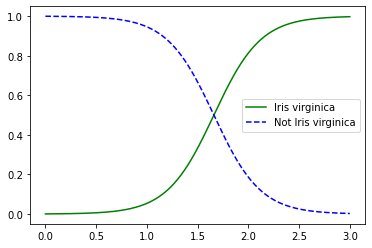

In [92]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X_new)
plt.plot(X_new, y_proba[:,1], 'g-', label = 'Iris virginica')
plt.plot(X_new, y_proba[:,0], 'b--', label = 'Not Iris virginica')
plt.legend()
plt.show()

In [93]:
log_reg.predict([[1.7], [1.5]])

array([1, 0])

In [94]:
log_reg.predict_proba([[1.7], [1.5]])

array([[0.45722097, 0.54277903],
       [0.66709636, 0.33290364]])

## 4.6.4 Softmax regression

The Logistic Regression model can be generalized to support multiple classes directly, without having to train and combine multiple binary classifiers (as discussed in Chapter 3). This is called Softmax Regression, or Multinomial Logistic Regression

The idea is simple: when given an instance x, the Softmax Regression model first computes a score s (x) for each class k, then estimates the probability of each class by applying the softmax function (also called the normalized exponential) to the scores. The equation to compute s (x) should look familiar, as it is just like the equation for Linear Regression prediction

Just like the Logistic Regression classifier, the Softmax Regression classifier predicts the class with the highest estimated probability (which is simply the class with the highest score)

The Softmax Regression classifier predicts only one class at a time (i.e., it is multiclass, not multioutput), so it should be used only with mutually exclusive classes, such as different types of plants. You cannot use it to recognize multiple people in one picture.

Cross entropy is frequently used to measure how well a set of estimated class probabilities matches the target classes.

Notice that when there are just two classes (K = 2), this cost function is equivalent to the Logistic Regression’s cost function

**Cross entropy:** Cross entropy originated from information theory. Suppose you want to efficiently transmit information about the weather every day. If there are eight options (sunny, rainy, etc.), you could encode each option using three bits because 2 = 8. However, if you think it will be sunny almost every day, it would be much more efficient to code “sunny” on just one bit (0) and the other seven options on four bits (starting with a 1). Cross entropy measures the average number of bits you actually send per option. If your assumption about the weather is perfect, cross entropy will be equal to the entropy of the weather itself (i.e., its intrinsic unpredictability). But if your assumptions are wrong (e.g., if it rains often), cross entropy will be greater by an amount called the Kullback– Leibler (KL) divergence.

Scikit-Learn’s LogisticRegression uses one-versus-the-rest by default when you train it on more than two classes, but you can set the multi_class hyperparameter to "multinomial" to switch it to Softmax Regression. You must also specify a solver that supports Softmax Regression, such as the "lbfgs" solver (see Scikit-Learn’s documentation for more details). It also applies ℓ regularization by default, which you can control using the hyperparameter C:

In [95]:
X = iris['data'][:, (2,3)] # petal length, petal width 
y = iris['target']

In [96]:
softmax_reg = LogisticRegression(multi_class = 'multinomial', solver = 'lbfgs', C = 10)
softmax_reg.fit(X, y)

LogisticRegression(C=10, multi_class='multinomial')

In [97]:
softmax_reg.predict([[5, 2]])

array([2])

In [98]:
softmax_reg.predict_proba([[5, 2]])

array([[6.38014896e-07, 5.74929995e-02, 9.42506362e-01]])